## Compare Between Odd/Even only and Odd-Even Messages

Normally, in ADS-B messages, both odd and even messages are required to decode position of an aircraft. However, even when only one message is obtained (either odd or even), the position can be decoded by using a reference position.

This notebook aims to compare the occurrence of odd/even only vs odd-even messages

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, sqrt, atan2

In [29]:
df1 = pd.read_csv('pos_tables/pos_table_1433801924_4320_2023-06-15.csv')
df2 = pd.read_csv('pos_tables/pos_table_1433801924_4320_2023-01-01.csv')

## Odd-Even Messages

In [30]:
df_list = [df1, df2]

df_filtered = []

for df_ in df_list:
    df_filtered_ = df_[['mintime', 'maxtime', 'rawmsg', 'icao24', 'lat', 'lon', 'alt', 'serial', 'nb_of_traffic']]
    df_filtered.append(df_filtered_)
    
    # df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
df = pd.concat(df_filtered)

df.drop_duplicates(subset=['rawmsg'], inplace = True)
df.dropna(subset=["lat"], inplace=True)
df.dropna(subset=["lon"], inplace=True)
df.dropna(subset=["lat"], inplace=True)

df_grouped = df.groupby('icao24', group_keys=True).apply(lambda x: x)
df_grouped['updateinterval'] = df_grouped['mintime'].diff()

df_grouped = df_grouped[(df_grouped['updateinterval'] > 0.0) & (df_grouped['updateinterval'] < 10)]
df = df_grouped.reset_index(drop=True)

df

,mintime,maxtime,rawmsg,icao24,lat,lon,alt,serial,nb_of_traffic,updateinterval
0,1.686917e+09,1.686917e+09,8d00000158bf0264245b1226afe3,000001,45.586761,1.561800,11277.6,1433801924,136,0.978
1,1.686917e+09,1.686917e+09,8d00000158bf0263f65b78516390,000001,45.585709,1.568633,11277.6,1433801924,136,2.111
2,1.686917e+09,1.686917e+09,8d00000158bf05e24c593d954d8f,000001,45.585720,1.568642,11277.6,1433801924,136,0.508
3,1.686917e+09,1.686917e+09,8d00000158bf0263d05bdc3e1979,000001,45.584839,1.575332,11277.6,1433801924,136,1.417
4,1.686917e+09,1.686917e+09,8d00000158bf05e21059d19e0e8b,000001,45.584324,1.578804,11277.6,1433801924,136,1.429
...,...,...,...,...,...,...,...,...,...,...
1886574,1.686846e+09,1.686846e+09,8de8042258ab05f19212fa42ab0c,e80422,45.676730,0.333572,10058.4,1433801924,119,0.438
1886575,1.686846e+09,1.686846e+09,8de8042258ab05f17212f2675bb6,e80422,45.675985,0.333023,10058.4,1433801924,119,0.520
1886576,1.686846e+09,1.686846e+09,8de8042258ab02730a13564c80b8,e80422,45.674057,0.331600,10058.4,1433801924,119,0.870
1886577,1.686846e+09,1.686846e+09,8de8042258ab0272ea134e426d89,e80422,45.673325,0.331064,10058.4,1433801924,119,0.420


In [31]:
nan_df = df['lat'].isna()
df['lat'][nan_df]

Series([], Name: lat, dtype: float64)

In [10]:
def haversine(lat1, lon1, lat_receiver, lon_receiver):
    R = 6371.0  # radius of the Earth in km

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat_receiver_rad = radians(lat_receiver)
    lon_receiver_rad = radians(lon_receiver)

    dlon = lon_receiver_rad - lon1_rad
    dlat = lat_receiver_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat_receiver_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance  # in km

lat_receiver = 43.57124934563629
lon_receiver = 1.4722830959048443

df['range_km'] = df.apply(lambda row: haversine(row['lat'], row['lon'], lat_receiver, lon_receiver), axis=1)
df['range_lat_km'] = df.apply(lambda row: haversine(row['lat'], lon_receiver, lat_receiver, lon_receiver), axis=1)
df['range_lon_km'] = df.apply(lambda row: haversine(lat_receiver, row['lon'], lat_receiver, lon_receiver), axis=1)

In [17]:
def get_cum(freq):
    cum_list = []
    cum = 0
    
    for f in freq:
        cum += f
        cum_list.append(cum)
        
    return np.array(cum_list)

In [18]:
start = 0.0
end = 5.0
nb_of_bar = 10

range_idx = 0

# fig, axs = plt.subplots(5, 8, figsize = (25,15))

within_p5s = []
within_1s = []

for df_traf in df_all_bin:
    traf_idx = 0
    
    within_p5s_ = []
    within_1s_ = []
    
    for df_loc in df_traf:
        input_list = np.array(df_loc['updateinterval'].to_list())
        
        bins = np.linspace(start, end, int(((end-start)*nb_of_bar+1)))
        weightsa = np.ones_like(input_list)/float(len(input_list))
        freq_, edge_ = np.histogram(input_list, bins, weights = weightsa)
        
        freq_ = np.array(freq_)
        edge_ = np.array(edge_)
        cum_ = get_cum(freq_)
        
        within_p5s_.append(cum_[edge_[:-1] == 0.8][0]*100)
        within_1s_.append(cum_[edge_[:-1] == 1.3][0]*100)
        
        traf_idx +=1
        
    within_p5s.append(within_p5s_)
    within_1s.append(within_1s_)
        
    range_idx +=1
    
# fig.text(0.5, 0.92, 'Range [km]', ha='center', fontsize=20)
# fig.text(0.08, 0.5, 'Nb of Aircraft [-]', va='center', rotation='vertical', fontsize=20)

[ 50 100 150 200 250 300 350]


(0.0, 8.0, 5.0, 0.0)

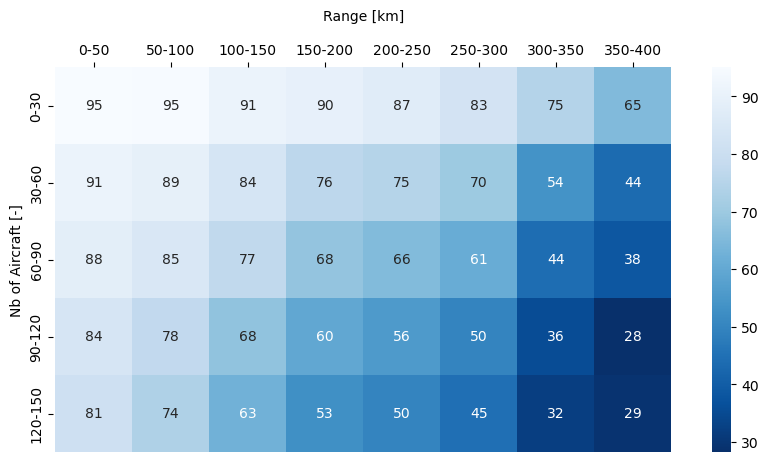

In [19]:
# Create a grid of x and y values
range_arr = np.arange(range_bin_width, max_range, range_bin_width)
traf_arr = np.arange(traf_bin_width, max_traf, traf_bin_width)
X, Y = np.meshgrid(range_arr, traf_arr)

print(range_arr)

# R_np = np.array(R_list)
within_1s_heatmap = np.array(within_1s).T
within_p5s_heatmap = np.array(within_p5s).T

# data_flipped = data_size[::-1]

range_labels = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(nb_of_cat_range)]
traf_labels = ['{}-{}'.format(i*traf_bin_width, (i+1)*traf_bin_width) for i in range(nb_of_cat_traf)]
# traf_labels = traf_labels[::-1]

# Create a filled contour plot
plt.figure(figsize=(10, 5))
cmap_reversed = plt.get_cmap('coolwarm_r')  # Get the reversed colormap
sns.heatmap(within_p5s_heatmap, annot=True, cmap='Blues_r', fmt='.0f', cbar=True, xticklabels=range_labels, yticklabels=traf_labels)
# Set axis labels and plot title
plt.xlabel('Range [km]')

ax = plt.gca()
ax.xaxis.set_label_coords(0.5, 1.15)  # Adjust the label position to be at the top
ax.xaxis.set_ticks_position('top')

plt.ylabel('Nb of Aircraft [-]')
plt.axis('equal')
# plt.title('Annotated Heatmap Example')

## Not dropping NaN in lat/lon column

In [21]:
df_list = [df1, df2]

df_filtered = []

for df_ in df_list:
    df_filtered_ = df_[['mintime', 'maxtime', 'rawmsg', 'icao24', 'lat', 'lon', 'alt', 'serial', 'nb_of_traffic']]
    df_filtered.append(df_filtered_)
    
    # df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
df = pd.concat(df_filtered)

df.drop_duplicates(subset=['rawmsg'], inplace = True)

df_grouped = df.groupby('icao24', group_keys=True).apply(lambda x: x)
df_grouped['updateinterval'] = df_grouped['mintime'].diff()

df_grouped = df_grouped[(df_grouped['updateinterval'] > 0.0) & (df_grouped['updateinterval'] < 10)]
df = df_grouped.reset_index(drop=True)

df

,mintime,maxtime,rawmsg,icao24,lat,lon,alt,serial,nb_of_traffic,updateinterval
0,1.686917e+09,1.686917e+09,8d00000158bf0264245b1226afe3,000001,45.586761,1.561800,11277.6,1433801924,136,0.978
1,1.686917e+09,1.686917e+09,8d00000158bf0263f65b78516390,000001,45.585709,1.568633,11277.6,1433801924,136,2.111
2,1.686917e+09,1.686917e+09,8d00000158bf05e24c593d954d8f,000001,45.585720,1.568642,11277.6,1433801924,136,0.508
3,1.686917e+09,1.686917e+09,8d00000158bf0263d05bdc3e1979,000001,45.584839,1.575332,11277.6,1433801924,136,1.417
4,1.686917e+09,1.686917e+09,8d00000158bf05e21059d19e0e8b,000001,45.584324,1.578804,11277.6,1433801924,136,1.429
...,...,...,...,...,...,...,...,...,...,...
1921943,1.686846e+09,1.686846e+09,8de8042258ab05f19212fa42ab0c,e80422,45.676730,0.333572,10058.4,1433801924,119,0.438
1921944,1.686846e+09,1.686846e+09,8de8042258ab05f17212f2675bb6,e80422,45.675985,0.333023,10058.4,1433801924,119,0.520
1921945,1.686846e+09,1.686846e+09,8de8042258ab02730a13564c80b8,e80422,45.674057,0.331600,10058.4,1433801924,119,0.870
1921946,1.686846e+09,1.686846e+09,8de8042258ab0272ea134e426d89,e80422,45.673325,0.331064,10058.4,1433801924,119,0.420


In [28]:
nan_df = df['lat'].isna()
df['lat'][nan_df]

123       NaN
158       NaN
161       NaN
162       NaN
176       NaN
           ..
1920383   NaN
1920384   NaN
1920753   NaN
1920754   NaN
1921684   NaN
Name: lat, Length: 28545, dtype: float64

In [22]:
def haversine(lat1, lon1, lat_receiver, lon_receiver):
    R = 6371.0  # radius of the Earth in km

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat_receiver_rad = radians(lat_receiver)
    lon_receiver_rad = radians(lon_receiver)

    dlon = lon_receiver_rad - lon1_rad
    dlat = lat_receiver_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat_receiver_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance  # in km

lat_receiver = 43.57124934563629
lon_receiver = 1.4722830959048443

df['range_km'] = df.apply(lambda row: haversine(row['lat'], row['lon'], lat_receiver, lon_receiver), axis=1)
df['range_lat_km'] = df.apply(lambda row: haversine(row['lat'], lon_receiver, lat_receiver, lon_receiver), axis=1)
df['range_lon_km'] = df.apply(lambda row: haversine(lat_receiver, row['lon'], lat_receiver, lon_receiver), axis=1)

In [23]:
start = 0.0
end = 5.0
nb_of_bar = 10

range_idx = 0

# fig, axs = plt.subplots(5, 8, figsize = (25,15))

within_p5s = []
within_1s = []

for df_traf in df_all_bin:
    traf_idx = 0
    
    within_p5s_ = []
    within_1s_ = []
    
    for df_loc in df_traf:
        input_list = np.array(df_loc['updateinterval'].to_list())
        
        bins = np.linspace(start, end, int(((end-start)*nb_of_bar+1)))
        weightsa = np.ones_like(input_list)/float(len(input_list))
        freq_, edge_ = np.histogram(input_list, bins, weights = weightsa)
        
        freq_ = np.array(freq_)
        edge_ = np.array(edge_)
        cum_ = get_cum(freq_)
        
        within_p5s_.append(cum_[edge_[:-1] == 0.8][0]*100)
        within_1s_.append(cum_[edge_[:-1] == 1.3][0]*100)
        
        traf_idx +=1
        
    within_p5s.append(within_p5s_)
    within_1s.append(within_1s_)
        
    range_idx +=1
    
# fig.text(0.5, 0.92, 'Range [km]', ha='center', fontsize=20)
# fig.text(0.08, 0.5, 'Nb of Aircraft [-]', va='center', rotation='vertical', fontsize=20)

[ 50 100 150 200 250 300 350]


(0.0, 8.0, 5.0, 0.0)

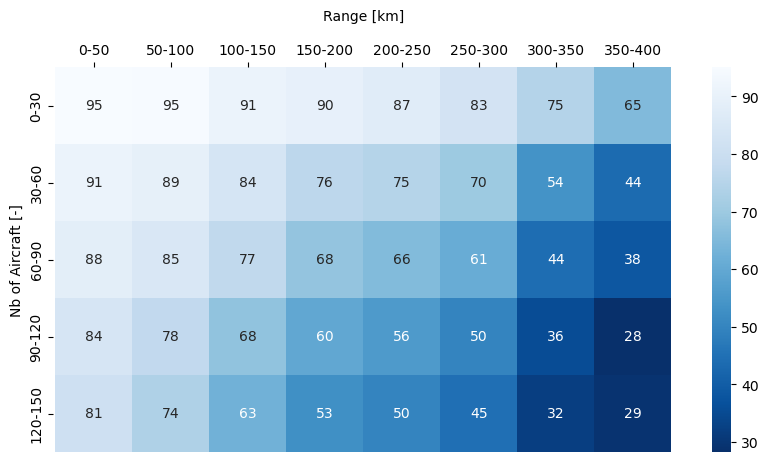

In [24]:
# Create a grid of x and y values
range_arr = np.arange(range_bin_width, max_range, range_bin_width)
traf_arr = np.arange(traf_bin_width, max_traf, traf_bin_width)
X, Y = np.meshgrid(range_arr, traf_arr)

print(range_arr)

# R_np = np.array(R_list)
within_1s_heatmap = np.array(within_1s).T
within_p5s_heatmap = np.array(within_p5s).T

# data_flipped = data_size[::-1]

range_labels = ['{}-{}'.format(i*range_bin_width, (i+1)*range_bin_width) for i in range(nb_of_cat_range)]
traf_labels = ['{}-{}'.format(i*traf_bin_width, (i+1)*traf_bin_width) for i in range(nb_of_cat_traf)]
# traf_labels = traf_labels[::-1]

# Create a filled contour plot
plt.figure(figsize=(10, 5))
cmap_reversed = plt.get_cmap('coolwarm_r')  # Get the reversed colormap
sns.heatmap(within_p5s_heatmap, annot=True, cmap='Blues_r', fmt='.0f', cbar=True, xticklabels=range_labels, yticklabels=traf_labels)
# Set axis labels and plot title
plt.xlabel('Range [km]')

ax = plt.gca()
ax.xaxis.set_label_coords(0.5, 1.15)  # Adjust the label position to be at the top
ax.xaxis.set_ticks_position('top')

plt.ylabel('Nb of Aircraft [-]')
plt.axis('equal')
# plt.title('Annotated Heatmap Example')